<a href="https://colab.research.google.com/github/faizkh7/Ronaldo_or_Messi-Image-Classifier/blob/main/fastai_no1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it Ronaldo or Messi

In [1]:
import os
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00


## Step 1: Download images of Ronaldo and Messi

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Ronaldo photos', max_images=1)
urls[0]

Searching for 'Ronaldo photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://newsmobile.in/wp-content/uploads/2020/02/ronaldo-1.jpg'

...and then download a URL and take a look at it:

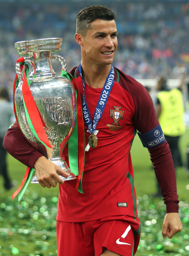

In [4]:
from fastdownload import download_url
dest = 'ronaldo.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "Messi photos":

Searching for 'Messi photos'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


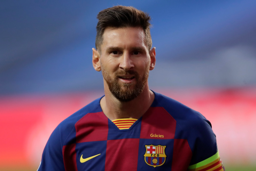

In [5]:
download_url(search_images('Messi photos', max_images=1)[0], 'messi.jpg', show_progress=False)
Image.open('messi.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "Ronaldo" and "Messi" photos, and save each group of photos to a different folder (I'm also trying to grab a range of jersey conditions here):

In [6]:
searches = 'Messi','Ronaldo'
path = Path('Ronaldo_or_Messi')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} club photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} international photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Messi photo'
Searching for 'Messi club photo'
Searching for 'Messi international photo'
Searching for 'Ronaldo photo'
Searching for 'Ronaldo club photo'
Searching for 'Ronaldo international photo'


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

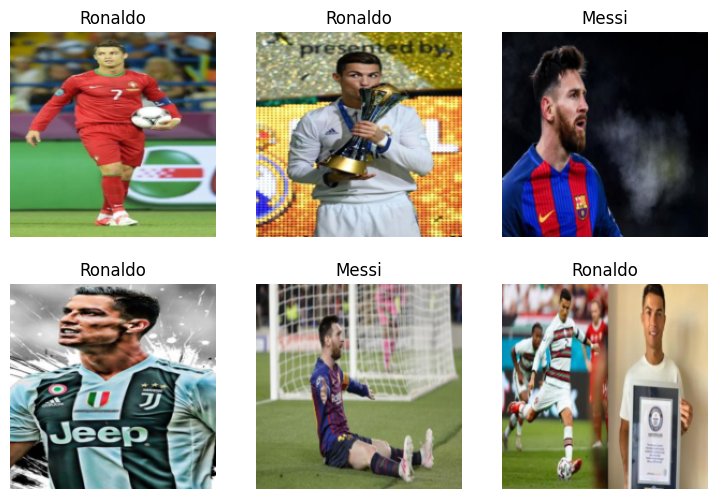

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.264964,3.180142,0.500000,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.831309,1.949492,0.466667,00:16
1,0.706484,1.315072,0.433333,00:15
2,0.547845,1.118410,0.366667,00:15
3,0.474312,1.056904,0.366667,00:15
4,0.388715,0.986245,0.333333,00:16
5,0.320537,0.922333,0.333333,00:15


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that Ronaldo pic we downloaded at the start:

In [12]:
is_Ronaldo_or_Messi,_,probs = learn.predict(PILImage.create('ronaldo.jpg'))
print(f"This is: {is_Ronaldo_or_Messi}.")
print(f"Probability it's Ronaldo: {probs[1]:.4f}")

This is: Ronaldo.
Probability it's Ronaldo: 0.9996
